In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

In [30]:
path="C:/Users/19178/Desktop/suwoon/미세먼지저감효과.csv"
final=pd.read_csv(path, encoding='utf-8')

In [13]:
final.sample(2)

,Unnamed: 0,정류장ID,총합,도로재비산심각도,최소최대정규화오염도,geometry,위치(동),sev,정류소ID,total,Exposure
790,247,201000074,0.141023,0.334357,0.000417,POINT (127.0153972 37.25443076),경기도 수원시 세류2동,0.169026,201000074,99105,16751.355746
772,80,200000118,0.071395,0.186249,0.004762,POINT (126.9898138 37.30795648),경기도 수원시 정자1동,0.091688,200000118,208216,19090.889154


In [31]:
# 위경도 정보 추출
import re
lonlat=[list(map(float,re.findall('\d+.\d+',i))) for i in final.geometry]

In [ ]:
final=final.drop('geometry',axis=1)

In [35]:
final['lon']=[i[0] for i in lonlat]
final['lat']=[i[1] for i in lonlat]

In [36]:
# df-> geopandas
geom_busstop=gpd.points_from_xy(final['lon'],final['lat'])
geom_busstop[0:3]

<GeometryArray>
Length: 3, dtype: geometry

In [38]:
import pyproj
from fiona.crs import from_epsg

In [43]:
final.columns

Index(['Unnamed: 0', '정류장ID', '총합', '도로재비산심각도', '최소최대정규화오염도', '위치(동)', 'sev',
       '정류소ID', 'total', 'Exposure', 'lon', 'lat'],
      dtype='object')

In [47]:
cols=['정류장ID', '총합', '도로재비산심각도', '최소최대정규화오염도','위치(동)', 'sev','Exposure','lat','lon']
gdf_busstop=gpd.GeoDataFrame(final[cols],geometry=geom_busstop,
                            crs=from_epsg(4326))
gdf_busstop.head(5)

C:\Users\19178\.conda\envs\gpd\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,정류장ID,총합,도로재비산심각도,최소최대정규화오염도,위치(동),sev,Exposure,lat,lon,geometry
0,202000219,0.419152,0.175779,0.000265,경기도 수원시 매산동,0.254941,1.188014e+07,37.267460,127.000934,POINT (127.00093 37.26746)
1,202000224,0.288980,0.264078,0.000310,경기도 수원시 매산동,0.218980,1.032149e+07,37.267314,127.003406,POINT (127.00341 37.26731)
2,202000208,0.668458,0.050646,0.000207,경기도 수원시 매산동,0.337110,9.639791e+06,37.268112,126.999608,POINT (126.99961 37.26811)
3,203000150,0.549781,0.176911,0.014492,경기도 수원시 태장동,0.321239,8.527425e+06,37.244730,127.056186,POINT (127.05619 37.24473)
4,202000106,0.424874,0.175779,0.000270,경기도 수원시 매산동,0.257696,8.343729e+06,37.267365,127.000904,POINT (127.00090 37.26737)


<AxesSubplot:>

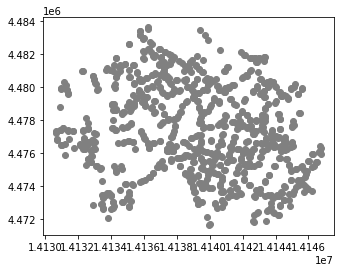

In [48]:
#좌표계를 epsg 3857로 변환: 거리 구할 때 정확함
gdf_busstop = gdf_busstop.to_crs(epsg=3857)  
gdf_busstop.plot(color='gray')

In [49]:
gdf_busstop.to_file('gdf_busstop.geojson', driver='GeoJSON')

### 군집화 (kmeans)

In [51]:
!pip install sklearn

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=28eff10b10917f641ad5396a98865f91194338b32cfdd09f8369d71805c1c34c
  Stored in directory: c:\users\19178\appdata\local\pip\cache\wheels\46\ef\c3\157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [54]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [55]:
from sklearn.cluster import KMeans 
import pandas as pd
import numpy as np
import math
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

### 최적의 k 찾기

C:\Users\19178\.conda\envs\gpd\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  f"KMeans is known to have a memory leak on Windows "
C:\Users\19178\.conda\envs\gpd\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


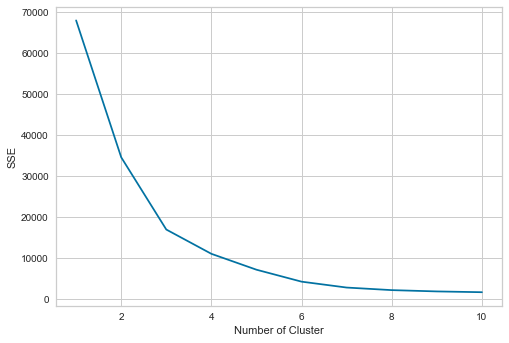

[68010.62873330178,
 34596.10527999801,
 16961.14690253213,
 11033.232836691008,
 7153.955427125096,
 4237.841967404746,
 2799.086736799304,
 2172.475191842752,
 1854.798187585257,
 1662.3803303689288]

In [121]:
def elbow(data):
    sse=[]
    for i in range(1,11):
        km=KMeans(n_clusters=i, init='k-means++', random_state=0)
        km.fit(X)
        sse.append(km.inertia_)
    sns.lineplot(range(1,11), sse)
    plt.xlabel('Number of Cluster')
    plt.ylabel('SSE')
    plt.show()
    return sse
elbow(target[['sev','total']])

C:\Users\19178\.conda\envs\gpd\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  f"KMeans is known to have a memory leak on Windows "
C:\Users\19178\.conda\envs\gpd\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


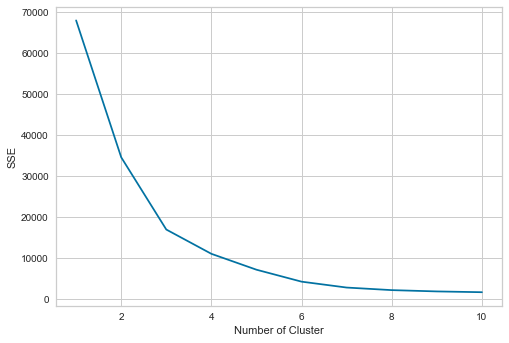

[68010.62873330178,
 34596.10527999801,
 16961.14690253213,
 11033.232836691008,
 7153.955427125096,
 4237.841967404746,
 2799.0867367993046,
 2172.475191842752,
 1854.798187585257,
 1662.3803303689288]

In [127]:
target['y']=1
target['Exposure']=final['Exposure']
elbow(target[['Exposure','y']])

In [144]:
kmeans2=KMeans(n_clusters=3,init='k-means++',random_state=0)
kmeans2.fit(target[['sev','total']])
target['cluster2']=pd.Categorical(kmeans2.labels_)

C:\Users\19178\.conda\envs\gpd\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [145]:
kmeans1=KMeans(n_clusters=3,init='k-means++',random_state=0)
kmeans1.fit(target[['Exposure','y']])
target['cluster1']=pd.Categorical(kmeans1.labels_)

C:\Users\19178\.conda\envs\gpd\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


No handles with labels found to put in legend.
No handles with labels found to put in legend.


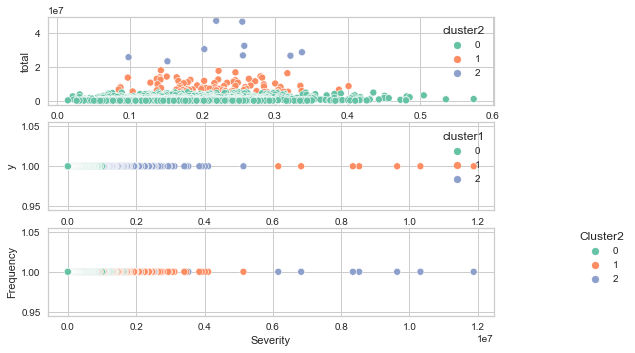

In [159]:
sns.set_palette('Set2')
fig, ax = plt.subplots(nrows=3)

sns.scatterplot(x='sev',y='total',hue='cluster2',data=target,palette='Set2',ax=ax[0])
plt.legend(title='Cluster2',bbox_to_anchor=(1.3,1),borderaxespad=0)
plt.xlabel('Severity')
plt.ylabel('Frequency')

sns.scatterplot(x='Exposure',y='y',hue='cluster1',data=target,palette='Set2',ax=ax[1])
plt.legend(title='Cluster1',bbox_to_anchor=(1.3,1),borderaxespad=0)

sns.scatterplot(x='Exposure',y='y',hue='cluster2',data=target,palette='Set2',ax=ax[2])
plt.legend(title='Cluster2',bbox_to_anchor=(1.3,1),borderaxespad=0)

In [158]:
target.groupby(by='cluster1').Exposure.mean()

cluster1
0    1.995135e+05
1    8.814440e+06
2    1.838200e+06
Name: Exposure, dtype: float64

In [162]:
kmeans1.score(target[['Exposure','y']])

-133870103113444.72

In [163]:
gdf_busstop['cluster1_k++3']=target.cluster1

### 계층적클러스터링

In [176]:
data=target[['Exposure','y']]
labels=[str(i) for i in range(len(data))]
data.index=labels

In [179]:
from scipy.spatial.distance import pdist, squareform

row_dist=pd.DataFrame(squareform(pdist(data,metric='euclidean')), columns=labels ,index=labels)

In [181]:
from sklearn.cluster import AgglomerativeClustering

In [183]:
ac=AgglomerativeClustering(n_clusters=3, affinity='euclidean',linkage='complete')
cluster_agg=ac.fit_predict(data)
target['cluster_agg']=cluster_agg

C:\Users\19178\.conda\envs\gpd\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


No handles with labels found to put in legend.


Text(0, 0.5, 'Frequency')

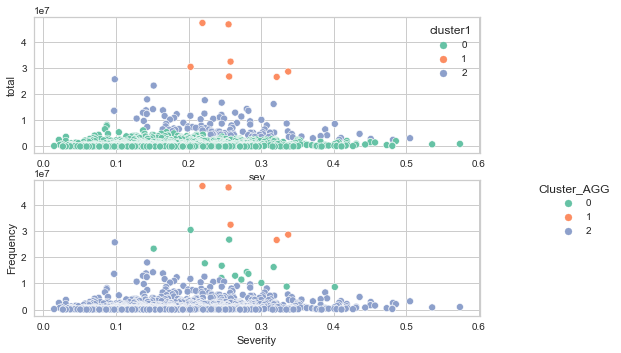

In [187]:
sns.set_palette('Set2')
fig, ax = plt.subplots(nrows=2)

sns.scatterplot(x='sev',y='total',hue='cluster1',data=target,palette='Set2',ax=ax[0])
plt.legend(title='Cluster2_Kmeans++',bbox_to_anchor=(1.3,1),borderaxespad=0)
plt.xlabel('Severity')
plt.ylabel('Frequency')


sns.scatterplot(x='sev',y='total',hue='cluster_agg',data=target,palette='Set2',ax=ax[1])
plt.legend(title='Cluster_AGG',bbox_to_anchor=(1.3,1),borderaxespad=0)
plt.xlabel('Severity')
plt.ylabel('Frequency')



No handles with labels found to put in legend.


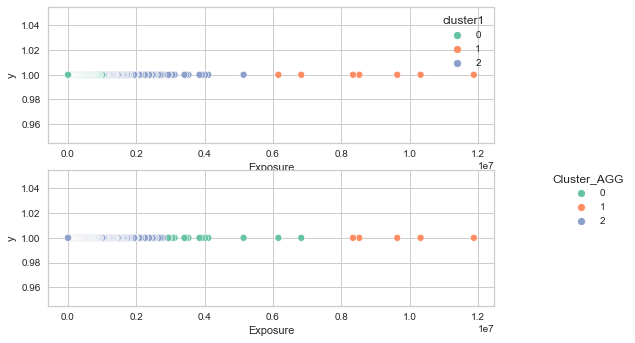

In [189]:
fig, ax = plt.subplots(nrows=2)

sns.scatterplot(x='Exposure',y='y',hue='cluster1',data=target,palette='Set2',ax=ax[0])
plt.legend(title='Cluster2_Kmeans++',bbox_to_anchor=(1.3,1),borderaxespad=0)

sns.scatterplot(x='Exposure',y='y',hue='cluster_agg',data=target,palette='Set2',ax=ax[1])
plt.legend(title='Cluster_AGG',bbox_to_anchor=(1.3,1),borderaxespad=0)

In [202]:
target.groupby(by='cluster1').count()

,sev,total,cluster,y,Exposure,cluster2,cluster_agg
cluster1,,,,,,,
0,805,805,805,805,805,805,805
1,7,7,7,7,7,7,7
2,107,107,107,107,107,107,107


In [201]:
target.groupby(by='cluster_agg').count()

,sev,total,cluster,y,Exposure,cluster1,cluster2
cluster_agg,,,,,,,
0,14,14,14,14,14,14,14
1,5,5,5,5,5,5,5
2,900,900,900,900,900,900,900
